# Co-occurrence network representation

Differentiating shuffled from real texts. Normalized by the size of the smallest book.

________________

In [1]:
!pip3 install python-igraph
!pip3 install xnetwork

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.8 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=84a52765eb7fa98567a17537c1afb9cb544b3077a9bb04639208901e13ee3baa
  Stored in directory: /root/.cache/pip/wheels/dc/07/ac/bff79052fd6222d1239b228cd24a47222f227c2350f9c4df01
Successfully built python-igraph
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from glob import glob
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import igraph

import xnetwork as xnet
import platform
import os

import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Loading books into vectors:

In [46]:
real_texts = []
shuffled_texts = []

real_index = []
shuffled_index = []


for filename in tqdm(glob('/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/real/*.txt')):
    with open(filename, encoding="utf8", errors='ignore') as f:      
        real_index.append(filename.split('/')[-1].split('_')[1])

        words = nltk.word_tokenize(f.read())      
        words = [word.lower() for word in words if word.isalpha()]
        
        real_texts.append(words)

        
for filename in tqdm(glob('/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/shuffled/*.txt')):
    with open(filename, encoding="utf8", errors='ignore') as f: 
        shuffled_index.append(filename.split('/')[-1].split('_')[1])

        words = nltk.word_tokenize(f.read())      
        words = [word.lower() for word in words if word.isalpha()]
        
        shuffled_texts.append(words)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Checking if previous processing went as expected:

In [5]:
print(real_texts[0])

['proofreading', 'team', 'illustration', 'maria', 'mitchell', 'life', 'letters', 'and', 'journals', 'compiled', 'by', 'illustrated', 'contents', 'the', 'parents', 'home', 'life', 'education', 'teachers', 'books', 'astronomical', 'instruments', 'solar', 'eclipse', 'of', 'teaching', 'appointment', 'as', 'librarian', 'of', 'nantucket', 'atheneum', 'friendships', 'for', 'young', 'people', 'extracts', 'from', 'diary', 'music', 'the', 'piano', 'society', 'housework', 'extract', 'from', 'diary', 'sweeping', 'the', 'heavens', 'discovery', 'of', 'the', 'comet', 'frederick', 'vi', 'and', 'the', 'comet', 'letters', 'from', 'bond', 'and', 'hon', 'edward', 'everett', 'admiral', 'smyth', 'american', 'academy', 'american', 'association', 'for', 'the', 'advancement', 'of', 'science', 'extract', 'from', 'diary', 'dorothea', 'dix', 'esther', 'divers', 'extracts', 'from', 'diary', 'comet', 'of', 'computations', 'for', 'comet', 'visit', 'to', 'cape', 'cod', 'sandwich', 'and', 'plymouth', 'pilgrim', 'hall'

Removing stopwords:

In [6]:
# Function responsible for removing words that are in the list 
#of stopwords in English. The entry is the list of words that make up the text.
def remove_stopwords(text_list):
    stop_list = stopwords.words('english')
    return [word for word in text_list if word not in stop_list]


for i in tqdm(range(len(real_texts))):
    real_texts[i] = remove_stopwords(real_texts[i])
    
for i in tqdm(range(len(shuffled_texts))):
    shuffled_texts[i] = remove_stopwords(shuffled_texts[i])

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Checking if previous processing went as expected:

In [7]:
print(real_texts[0])

['proofreading', 'team', 'illustration', 'maria', 'mitchell', 'life', 'letters', 'journals', 'compiled', 'illustrated', 'contents', 'parents', 'home', 'life', 'education', 'teachers', 'books', 'astronomical', 'instruments', 'solar', 'eclipse', 'teaching', 'appointment', 'librarian', 'nantucket', 'atheneum', 'friendships', 'young', 'people', 'extracts', 'diary', 'music', 'piano', 'society', 'housework', 'extract', 'diary', 'sweeping', 'heavens', 'discovery', 'comet', 'frederick', 'vi', 'comet', 'letters', 'bond', 'hon', 'edward', 'everett', 'admiral', 'smyth', 'american', 'academy', 'american', 'association', 'advancement', 'science', 'extract', 'diary', 'dorothea', 'dix', 'esther', 'divers', 'extracts', 'diary', 'comet', 'computations', 'comet', 'visit', 'cape', 'cod', 'sandwich', 'plymouth', 'pilgrim', 'hall', 'rev', 'james', 'freeman', 'clarke', 'accidents', 'observing', 'wires', 'transit', 'instrument', 'deacon', 'greele', 'smithsonian', 'fund', 'rachel', 'phèdre', 'adrienne', 'emer

Next, POSTagging is going to be used to do the stemming. For this purpose we're using NLTK tagger, as follows.

In [8]:
real_texts_tw = []
shuffled_texts_tw = []


for i in tqdm(range(len(real_texts))):
    real_texts_tw.append(nltk.pos_tag(real_texts[i]))
    
for i in tqdm(range(len(shuffled_texts))):
    shuffled_texts_tw.append(nltk.pos_tag(shuffled_texts[i]))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
print(real_texts_tw[0])

[('proofreading', 'VBG'), ('team', 'NN'), ('illustration', 'NN'), ('maria', 'NN'), ('mitchell', 'NN'), ('life', 'NN'), ('letters', 'NNS'), ('journals', 'NNS'), ('compiled', 'VBD'), ('illustrated', 'JJ'), ('contents', 'NNS'), ('parents', 'NNS'), ('home', 'NN'), ('life', 'NN'), ('education', 'NN'), ('teachers', 'NNS'), ('books', 'NNS'), ('astronomical', 'JJ'), ('instruments', 'NNS'), ('solar', 'JJ'), ('eclipse', 'NN'), ('teaching', 'VBG'), ('appointment', 'JJ'), ('librarian', 'JJ'), ('nantucket', 'NN'), ('atheneum', 'NN'), ('friendships', 'NNS'), ('young', 'JJ'), ('people', 'NNS'), ('extracts', 'VBZ'), ('diary', 'JJ'), ('music', 'NN'), ('piano', 'NN'), ('society', 'NN'), ('housework', 'NN'), ('extract', 'JJ'), ('diary', 'JJ'), ('sweeping', 'NN'), ('heavens', 'NNS'), ('discovery', 'VBP'), ('comet', 'NN'), ('frederick', 'NN'), ('vi', 'NN'), ('comet', 'VBD'), ('letters', 'NNS'), ('bond', 'NN'), ('hon', 'NN'), ('edward', 'RB'), ('everett', 'VBZ'), ('admiral', 'JJ'), ('smyth', 'JJ'), ('americ

The tags identified by the NLTK tagger need to be adjusted to be used in WordNetLemmatizer.

The following functions perform the processing described above:

In [10]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def convert_to_wn(tag):
    return get_wordnet_pos(tag)

Converting the NLTK tags to the WordNet format:

In [11]:
real_texts_wt = []
shuffled_texts_wt = []


for i in tqdm(range(len(real_texts_tw))):
    real_texts_wt.append([convert_to_wn(tag[1]) for tag in real_texts_tw[i]])
    
for i in tqdm(range(len(shuffled_texts_tw))):
    shuffled_texts_wt.append([convert_to_wn(tag[1]) for tag in shuffled_texts_tw[i]])   

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [12]:
print(real_texts_wt[0])

['v', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'v', 'a', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'a', 'n', 'a', 'n', 'v', 'a', 'a', 'n', 'n', 'n', 'a', 'n', 'v', 'a', 'n', 'n', 'n', 'n', 'a', 'a', 'n', 'n', 'v', 'n', 'n', 'n', 'v', 'n', 'n', 'n', 'r', 'v', 'a', 'a', 'a', 'n', 'a', 'n', 'n', 'n', 'a', 'a', 'n', 'n', 'n', 'n', 'v', 'a', 'n', 'n', 'v', 'n', 'n', 'n', 'n', 'n', 'v', 'n', 'n', 'n', 'a', 'a', 'n', 'v', 'n', 'v', 'a', 'n', 'n', 'a', 'n', 'n', 'n', 'n', 'a', 'a', 'n', 'a', 'n', 'n', 'n', 'a', 'n', 'n', 'v', 'a', 'n', 'n', 'v', 'n', 'v', 'a', 'a', 'a', 'n', 'v', 'n', 'a', 'n', 'a', 'n', 'a', 'n', 'n', 'v', 'n', 'n', 'n', 'n', 'n', 'v', 'n', 'v', 'a', 'n', 'n', 'n', 'v', 'a', 'n', 'v', 'n', 'n', 'n', 'n', 'n', 'n', 'v', 'n', 'n', 'n', 'v', 'n', 'n', 'n', 'n', 'n', 'a', 'n', 'n', 'n', 'v', 'n', 'v', 'n', 'a', 'a', 'n', 'n', 'n', 'n', 'n', 'v', 'a', 'n', 'n', 'a', 'n', 'n', 'n', 'v', 'a', 'n', 'n', 'a', 'n', 'v', 'a', 'a', 'n', 'n', 'n', 'n', 'a', 'n', 'n', 'n', 'a', 'n', 'a', 'n', 'n', 'a',

Finally doing the text stemming (based on the true tag of each word):

In [13]:
real_texts_lemm = []
shuffled_texts_lemm = []


for i in tqdm(range(len(real_texts_wt))):
    real_texts_lemm.append([WordNetLemmatizer().lemmatize(word, tag) for word, tag in zip(real_texts[i],
                            real_texts_wt[i])])

for i in tqdm(range(len(shuffled_texts_wt))):
    shuffled_texts_lemm.append([WordNetLemmatizer().lemmatize(word, tag) for word, tag in zip(shuffled_texts[i],
                            shuffled_texts_wt[i])])

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Final result: set of words from each book without punctuation, numbers, capital letters and stopwords and with the performed stemming.

In [14]:
print(real_texts_lemm[0])

['proofread', 'team', 'illustration', 'maria', 'mitchell', 'life', 'letter', 'journal', 'compile', 'illustrated', 'content', 'parent', 'home', 'life', 'education', 'teacher', 'book', 'astronomical', 'instrument', 'solar', 'eclipse', 'teach', 'appointment', 'librarian', 'nantucket', 'atheneum', 'friendship', 'young', 'people', 'extract', 'diary', 'music', 'piano', 'society', 'housework', 'extract', 'diary', 'sweeping', 'heaven', 'discovery', 'comet', 'frederick', 'vi', 'comet', 'letter', 'bond', 'hon', 'edward', 'everett', 'admiral', 'smyth', 'american', 'academy', 'american', 'association', 'advancement', 'science', 'extract', 'diary', 'dorothea', 'dix', 'esther', 'diver', 'extract', 'diary', 'comet', 'computation', 'comet', 'visit', 'cape', 'cod', 'sandwich', 'plymouth', 'pilgrim', 'hall', 'rev', 'james', 'freeman', 'clarke', 'accident', 'observe', 'wire', 'transit', 'instrument', 'deacon', 'greele', 'smithsonian', 'fund', 'rachel', 'phèdre', 'adrienne', 'emerson', 'hard', 'winter', '

Finding the book with the fewest words:

In [15]:
min_sz = float('inf')

for i in range(len(real_texts_lemm)):
    min_sz = min(min_sz, len(real_texts_lemm[i]))
    
print("Minimum number of words: ", min_sz)

Minimum number of words:  8306


Normalizing the network so that all books have *min_sz* words.

In [16]:
real_books_final = [['']] * len(real_texts_lemm)
shuffled_books_final = [['']] * len(shuffled_texts_lemm)
temp = []


i = 0
for outter_list in real_texts_lemm:
    temp.clear()
    
    for j in range(len(outter_list)):
#         temp.append(outter_list[j])
        if j < min_sz: temp.append(outter_list[j])
        else: break
        
    real_books_final[i] = temp.copy()
            
    i = i + 1
    
i = 0
for outter_list in shuffled_texts_lemm:
    temp.clear()
    
    for j in range(len(outter_list)):
#         temp.append(outter_list[j])
        if j < min_sz: temp.append(outter_list[j])
        else: break
        
    shuffled_books_final[i] = temp.copy()
            
    i = i + 1

In [17]:
print(len(real_books_final[0]), len(real_books_final[299]))
print(len(shuffled_books_final[0]), len(shuffled_books_final[299]))

8306 8306
8306 8306


Next, we will create the co-occurrence network with $window = 1$.

Auxiliary function (used in the CNetwork class) that returns, in a list of words, the $w$ neighbors of a given word:

In [18]:
def get_neighbors(word_list, index, w):
    # picking w neighbors from the left 
#     if index - w >= 0:
#         left = word_list[index - w:index]
#     else:
#         left = word_list[:index]
    
    # picking w neighbors from the right
    right = word_list[index + 1:index + 1 + w]
    
    #return set(left + right)
    return set(right)

For a better organization, we created the *CNetwork* class, which implements the creation of a network from an input text and a user-defined window.

The class' *get_network* function creates an adjacency matrix where all the relationships between words will be stored. It searches for the neighboring $w$ for each word and then stores those relationships in the adjacency matrix. Finally, this matrix serves as input for the function *igraph.Graph.Adjacency*, which receives an adjacency matrix and then returns the network that corresponds to the input text.

In [19]:
class CNetwork(object):
    
    def __init__(self, text, window):
        self.document = text
        self.words = set(self.document)
        # each word receives a identifier number --> self.vocab.index['test'], 3
        self.vocab_index = {word:i for i, word in enumerate(self.words)}
        self.window = window
    
    def get_network(self):
        # adjacency Matrix
        matrix = np.zeros((len(self.words), len(self.words)))
        
        # going through all the words in the network, including the repeated ones
        for index, word in enumerate(self.document):
            # passing the text, the current position of the word and the window and 
            #returning a list with the neighbors
            neighbors = get_neighbors(self.document, index, self.window)
            word_index = self.vocab_index[word]
            
            # indicates neighbors in the co-occurrence matrix
            for neighbor in neighbors:
                neighbor_index = self.vocab_index[neighbor]
                matrix[word_index][neighbor_index] = 1
                matrix[neighbor_index][word_index] = 1
            
        np.fill_diagonal(matrix, 0)
        network = igraph.Graph.Adjacency(matrix.tolist(), mode= "undirected")
        network.vs['name'] = list(self.words)
        
        return network

Generating the coocurrence network for all successfull books:

In [20]:
real_objs = []
real_nets = []
shuffled_objs = []
shuffled_nets = []


for i in tqdm(range(len(real_books_final))):
    real_objs.append(CNetwork(real_books_final[i], 1))
    real_nets.append(real_objs[i].get_network()) 

for i in tqdm(range(len(shuffled_books_final))):
    shuffled_objs.append(CNetwork(shuffled_books_final[i], 1))
    shuffled_nets.append(shuffled_objs[i].get_network()) 

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Checking the obtained results:

In [21]:
print('Number of network nodes:',real_nets[0].vcount())
#print('Network nodes:', network[1].vs['name'])
print('Number of edges:', len(real_nets[0].get_edgelist()))
print('Edge list:',real_nets[0].get_edgelist()) 

Number of network nodes: 2694
Number of edges: 7784
Edge list: [(0, 138), (0, 1536), (1, 11), (1, 76), (1, 873), (1, 1086), (1, 1242), (1, 1443), (1, 1574), (1, 1652), (1, 2044), (1, 2291), (2, 1106), (2, 1996), (3, 451), (3, 2332), (4, 2226), (4, 2323), (5, 87), (5, 89), (5, 562), (5, 671), (5, 999), (5, 1023), (5, 1085), (5, 1217), (5, 1270), (5, 1472), (5, 1513), (5, 1561), (5, 1973), (5, 2193), (5, 2208), (5, 2240), (5, 2291), (6, 1666), (6, 2371), (7, 1401), (7, 2681), (8, 628), (8, 1637), (9, 1314), (9, 2680), (10, 272), (10, 1188), (10, 1211), (10, 1652), (10, 1654), (10, 2397), (11, 1168), (12, 1358), (12, 2125), (13, 1520), (13, 1635), (14, 835), (14, 1450), (15, 245), (15, 655), (15, 1515), (15, 1877), (15, 2329), (15, 2574), (16, 1371), (16, 2375), (17, 1533), (17, 1857), (18, 2067), (18, 2228), (19, 107), (19, 255), (19, 365), (19, 430), (19, 629), (19, 694), (19, 1101), (19, 1980), (19, 2291), (19, 2301), (20, 668), (20, 669), (20, 2547), (21, 685), (21, 1964), (22, 1539),

In [22]:
teste = real_nets[0].get_edgelist()

for el in teste:
    print(real_nets[0].vs['name'][el[0]] + " -> " + real_nets[0].vs['name'][el[1]])

A saída de streaming foi truncada nas últimas 5000 linhas.
regard -> descend
idle -> visitor
idle -> never
bad -> could
bad -> much
bad -> get
bad -> condition
bad -> place
thus -> enable
thus -> entail
thus -> nantucket
thus -> music
computer -> work
computer -> act
duty -> addition
duty -> morning
duty -> family
duty -> safely
duty -> feel
duty -> know
humility -> fit
humility -> trouble
relapse -> natural
relapse -> instantly
heaven -> could
heaven -> discovery
heaven -> stone
heaven -> even
heaven -> child
heaven -> matter
heaven -> sweep
heaven -> sweeping
logarithms -> column
logarithms -> bless
rating -> descends
rating -> value
young -> sailor
young -> cultivate
young -> friend
young -> library
young -> quaker
young -> brother
young -> several
young -> mitchell
young -> live
young -> bond
young -> great
young -> assist
young -> quietly
young -> daughter
young -> letter
young -> reading
young -> dozen
young -> care
young -> april
young -> coax
young -> charge
young -> priest
you

Collecting metrics from networks:

In [23]:
df_data = pd.DataFrame(data = np.zeros((len(real_nets) + len(shuffled_nets), 7)), 
                        columns = ["accessibility_h2_mean", "accessibility_h2_std", 
                                   "backbone_symmetry_h2_mean", "backbone_symmetry_h2_std",
                                   "merged_symmetry_h2_mean", "merged_symmetry_h2_std", "Category"])

df_data

,accessibility_h2_mean,accessibility_h2_std,backbone_symmetry_h2_mean,backbone_symmetry_h2_std,merged_symmetry_h2_mean,merged_symmetry_h2_std,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
path = ["/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/real/measures/accessibility_h2",
        "/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/real/measures/simmetry_h2",
        "/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/shuffled/measures/accessibility_h2",
        "/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/shuffled/measures/simmetry_h2"]

features = ["accessibility_h2", "backbone_symmetry_h2", "merged_symmetry_h2"]

tsv_columns = ["Backbone Accessibility h=2", "Merged Accessibility h=2"]

In [25]:
for feature in tqdm(features):
    for book in range(len(real_nets) + len(shuffled_nets)):
        if(feature.split('_')[0] == "backbone" or feature.split('_')[0] == "merged"):
            if book < len(real_nets): 
                inFileName = path[1] + "/book_%s.tsv" % book

            else:
                inFileName = path[3] + "/book_%s.tsv" % (book - len(real_nets))
            
            data = pd.read_csv(inFileName, sep = "\t", usecols = tsv_columns, header = 0, dtype = float, 
                               float_precision='round_trip')
                                        
            if feature.split('_')[0] == "backbone":
                df_data.loc[book, f'{feature}_mean'] = np.nanmean(data.iloc[:, 0])
                df_data.loc[book, f'{feature}_std'] = np.nanstd(data.iloc[:, 0])
                
            else:
                df_data.loc[book, f'{feature}_mean'] = np.nanmean(data.iloc[:, 1])
                df_data.loc[book, f'{feature}_std'] = np.nanstd(data.iloc[:, 1])
                
        else:
            if book < len(real_nets): 
                inFileName = path[0] + "/book_%s.txt" % book

            else:
                inFileName = path[2] + "/book_%s.txt" % (book - len(real_nets))
                
            file = open(inFileName, "r")

            data = [float(line) for line in file]
            data = [x for x in data if str(x) != "nan"]

            df_data.loc[book, f'{feature}_mean'] = np.mean(data)
            df_data.loc[book, f'{feature}_std'] = np.std(data)

df_data["Category"] = ["Real"] * len(real_nets) + ["Meaningless"] * len(shuffled_nets)
       
df_data.head(len(real_nets) + len(shuffled_nets))

  0%|          | 0/3 [00:00<?, ?it/s]

,accessibility_h2_mean,accessibility_h2_std,backbone_symmetry_h2_mean,backbone_symmetry_h2_std,merged_symmetry_h2_mean,merged_symmetry_h2_std,Category
0,46.374204,59.427237,0.654609,0.231327,0.430187,0.310786,Real
1,51.904077,65.037392,0.621291,0.248365,0.371600,0.306277,Real
2,41.583473,56.400035,0.641336,0.240911,0.442191,0.311276,Real
3,85.217974,85.419105,0.612981,0.226770,0.251655,0.263377,Real
4,50.373530,60.776733,0.627098,0.243870,0.389312,0.310394,Real
...,...,...,...,...,...,...,...
595,56.448906,70.670538,0.598521,0.251816,0.343868,0.308601,Meaningless
596,49.036109,61.779491,0.623410,0.239190,0.398157,0.304508,Meaningless
597,32.976339,43.016856,0.671184,0.227889,0.537945,0.297670,Meaningless
598,41.942518,52.385810,0.652236,0.227380,0.471691,0.302683,Meaningless


Plotting it:

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import math 


# Root mean square error (rmse)
def calc_separation_score(x, y):
    x = x[0]
    y = y[0]
    
    score = 0
    for i in range(29):
        score += (x[i] - y[i])**2

    score /= 29
    score = math.sqrt(score)
    return round(score, 4)


def rmse(y_actual, y_predicted):
    y_actual = y_actual[0]
    y_predicted = y_predicted[0]
    return round(sqrt(mean_squared_error(y_actual, y_predicted)), 4)

In [27]:
import matplotlib

def set_plot_params():
    sns.set(font_scale = 1.0)
    sns.set_style('white')
    plt.rcParams.update({'font.size': 12})
    custom_palette = ["#1f77b4", "#ff7f0e"]
    sns.set_palette(palette = custom_palette)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

In [28]:
import sys
import inspect
import scipy.stats

def CountQuads(Arr2D, point):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by counting
    the proportion of points in Arr2D in each quadrant.
    :param list Arr2D: Array of points to be counted.
    :param array point: A 2 element list, point, which is the center of
    4 square quadrants.
    :returns: a tuple of 4 floats.  The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive, n for
    negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is neither list nor numpyndarray')
    if len(point) != 2:
        return
    if isinstance(Arr2D, list):
        Arr2D = np.asarray((Arr2D))
    elif type(Arr2D).__module__+type(Arr2D).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D is neither list nor numpyndarray')
    if Arr2D.shape[1] > Arr2D.shape[0]:  # Reshape to A[row,column]
        Arr2D = Arr2D.copy().T
    if Arr2D.shape[1] != 2:
        raise TypeError('Input Arr2D is not 2D')
    # The pp of Qpp refer to p for 'positive' and n for 'negative' quadrants.
    # In order. first subscript is x, second is y.
    Qpp = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qnp = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] > point[1]), :]
    Qpn = Arr2D[(Arr2D[:, 0] > point[0]) & (Arr2D[:, 1] < point[1]), :]
    Qnn = Arr2D[(Arr2D[:, 0] < point[0]) & (Arr2D[:, 1] < point[1]), :]
    # Normalized fractions:
    ff = 1./len(Arr2D)
    fpp = len(Qpp)*ff
    fnp = len(Qnp)*ff
    fpn = len(Qpn)*ff
    fnn = len(Qnn)*ff
    # NOTE:  all the f's are supposed to sum to 1.0. Float representation
    # cause SOMETIMES sum to 1.000000002 or something. I don't know how to
    # test for that reliably, OR what to do about it yet. Keep in mind.
    return(fpp, fnp, fpn, fnn)


def FuncQuads(func2D, point, xlim, ylim, rounddig=4):
    """ Computes the probabilities of finding points in each 4 quadrant
    defined by a vertical and horizontal lines crossing the point, by
    integrating the density function func2D in each quadrant.
    :param array func2D: Density function that takes 2 arguments: x and y.
    :param list point: A 2 element list, point, which is the center of 4
    square quadrants.
    :param array xlim,ylim: Domain of numerical integration necessary to
    compute the quadrant probabilities.
    :returns: a tuple of 4 floats. The probabilities of finding a point in
    each quadrants, with point as the origin.  p stands for positive,
    n for negative, with the first and second positions meaning the x and y
    directions respectively.
    """
    if callable(func2D):
        if len(inspect.getfullargspec(func2D)[0]) != 2:
            raise TypeError('Input func2D is not a function with 2 arguments')
        pass
    else:
        raise TypeError('Input func2D is not a function')
    # If xlim, ylim and point are not lists or ndarray, exit.
    if isinstance(point, list):
        point = np.asarray((np.ravel(point)))
    elif type(point).__module__+type(point).__name__ == 'numpyndarray':
        point = np.ravel(point.copy())
    else:
        raise TypeError('Input point is not a list or numpyndarray')
    if len(point) != 2:
        raise TypeError('Input point has not exactly 2 elements')
    if isinstance(xlim, list):
        xlim = np.asarray((np.sort(np.ravel(xlim))))
    elif type(xlim).__module__+type(xlim).__name__ == 'numpyndarray':
        xlim = np.sort(np.ravel(xlim.copy()))
    else:
        raise TypeError('Input xlim is not a list or ndarray')
    if len(xlim) != 2:
        raise TypeError('Input xlim has not exactly 2 elements')
    if xlim[0] == xlim[1]:
        raise TypeError('Input xlim[0] should be different to xlim[1]')
    if isinstance(ylim, list):
        ylim = np.asarray((np.sort(np.ravel(ylim))))
    elif type(ylim).__module__+type(ylim).__name__ == 'numpyndarray':
        ylim = np.sort(np.ravel(ylim.copy()))
    else:
        raise TypeError('Input ylim is not a list or ndarray')
    if len(ylim) != 2:
        raise TypeError('Input ylim has not exactly 2 elements')
    if ylim[0] == ylim[1]:
        raise TypeError('Input ylim[0] should be different to ylim[1]')
    # Numerical integration to find the quadrant probabilities.
    totInt = scipy.integrate.dblquad(func2D, *xlim,
                                     lambda x: np.amin(ylim),
                                     lambda x: np.amax(ylim))[0]
    Qpp = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qpn = scipy.integrate.dblquad(func2D, point[0], np.amax(xlim),
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    Qnp = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: point[1],
                                  lambda x: np.amax(ylim))[0]
    Qnn = scipy.integrate.dblquad(func2D, np.amin(xlim), point[0],
                                  lambda x: np.amin(ylim),
                                  lambda x: point[1])[0]
    fpp = round(Qpp/totInt, rounddig)
    fnp = round(Qnp/totInt, rounddig)
    fpn = round(Qpn/totInt, rounddig)
    fnn = round(Qnn/totInt, rounddig)
    return(fpp, fnp, fpn, fnn)


def Qks(alam, iter=100, prec=1e-17):
    """ Computes the value of the KS probability function, as a function of
    alam, the D statistic. From *Numerical recipes in C* page 623: '[...]
    the K–S statistic useful is that its distribution in the case of the null
    hypothesis (data sets drawn from the same distribution) can be calculated,
    at least to useful approximation, thus giving the significance of any
    observed nonzero value of D.' (D being the KS statistic).
    :param float alam: D statistic.
    :param int iter: Number of iterations to be perfomed. On non-convergence,
    returns 1.0.
    :param float prec: Convergence criteria of the qks. Stops converging if
    that precision is attained.
    :returns: a float. The significance level of the observed D statistic.
    """
    # If j iterations are performed, meaning that toadd
    # is still 2 times larger than the precision.
    if isinstance(alam, int) | isinstance(alam, float):
        pass
    else:
        raise TypeError('Input alam is neither int nor float')
    toadd = [1]
    qks = 0.
    j = 1
    while (j < iter) & (abs(toadd[-1]) > prec*2):
        toadd.append(2.*(-1.)**(j-1.)*np.exp(-2.*j**2.*alam**2.))
        qks += toadd[-1]
        j += 1
    if (j == iter) | (qks > 1):  # If no convergence after j iter, return 1.0
        return(1.0)
    if qks < prec:
        return(0.)
    else:
        return(qks)


def ks2d2s(Arr2D1, Arr2D2):
    """ ks stands for Kolmogorov-Smirnov, 2d for 2 dimensional,
    2s for 2 samples.
    KS test for goodness-of-fit on two 2D samples. Tests the hypothesis that
    the two samples are from the same distribution.
    :param array Arr2D1: 2D array of points/samples.
    :param array Arr2D2: 2D array of points/samples.
    :returns: a tuple of two floats. First, the two-sample K-S statistic.
    If this value is higher than the significance level of the hypothesis,
    it is rejected. Second, the significance level of *d*. Small values of
    prob show that the two samples are significantly different.
    """
    if type(Arr2D1).__module__+type(Arr2D1).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D1 is neither list nor numpyndarray')
    if Arr2D1.shape[1] > Arr2D1.shape[0]:
        Arr2D1 = Arr2D1.copy().T
    if type(Arr2D2).__module__+type(Arr2D2).__name__ == 'numpyndarray':
        pass
    else:
        raise TypeError('Input Arr2D2 is neither list nor numpyndarray')
    if Arr2D2.shape[1] > Arr2D2.shape[0]:
        Arr2D2 = Arr2D2.copy().T
    if Arr2D1.shape[1] != 2:
        raise TypeError('Input Arr2D1 is not 2D')
    if Arr2D2.shape[1] != 2:
        raise TypeError('Input Arr2D2 is not 2D')
    d1, d2 = 0., 0.
    for point1 in Arr2D1:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point1)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point1)
        d1 = max(d1, abs(fpp1-fpp2))
        d1 = max(d1, abs(fpm1-fpm2))
        d1 = max(d1, abs(fmp1-fmp2))
        d1 = max(d1, abs(fmm1-fmm2))
    for point2 in Arr2D2:
        fpp1, fmp1, fpm1, fmm1 = CountQuads(Arr2D1, point2)
        fpp2, fmp2, fpm2, fmm2 = CountQuads(Arr2D2, point2)
        d2 = max(d2, abs(fpp1-fpp2))
        d2 = max(d2, abs(fpm1-fpm2))
        d2 = max(d2, abs(fmp1-fmp2))
        d2 = max(d2, abs(fmm1-fmm2))
    d = (d1+d2)/2.
    sqen = np.sqrt(len(Arr2D1)*len(Arr2D2)/(len(Arr2D1)+len(Arr2D2)))
    R1 = scipy.stats.pearsonr(Arr2D1[:, 0], Arr2D1[:, 1])[0]
    R2 = scipy.stats.pearsonr(Arr2D2[:, 0], Arr2D2[:, 1])[0]
    RR = np.sqrt(1.-(R1*R1+R2*R2)/2.)
    prob = Qks(d*sqen/(1.+RR*(0.25-0.75/sqen)))
    # Small values of prob show that the two samples are significantly
    # different. Prob is the significance level of an observed value of d.
    # NOT the same as the significance level that ou set and compare to D.
    #return(d, prob)
    return round(d, 4)

In [29]:
df = pd.DataFrame()
df['means'] = df_data['accessibility_h2_mean'].copy()
df['stds'] = df_data['accessibility_h2_std'].copy()
df['targets'] = df_data['Category'].copy()

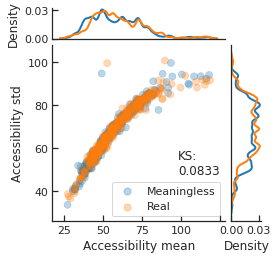

In [31]:
set_plot_params()

grid = sns.JointGrid(x=df.sort_values('targets')['means'], y=df.sort_values('targets')['stds'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, 
                    alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Accessibility std')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[0], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="lower right", scatterpoints=1)
for lh in leg.legend_handles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='Meaningless', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='Real', 'means'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='Meaningless', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='Real', 'stds'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0.00, 0.03])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(98, 48, "KS:\n" + 
                str(ks2d2s(np.array(df.loc[df['targets']=='Real', ['means', 'stds']]), 
                    np.array(df.loc[df['targets']=='Meaningless', ['means', 'stds']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access_mean_std.pdf', bbox_inches='tight', dpi=300)
plt.show()

_______________

In [32]:
df = pd.DataFrame()
df['accessibilities'] = df_data['accessibility_h2_mean'].copy()
df['symmetries'] = df_data['backbone_symmetry_h2_mean'].copy()
df['targets'] = df_data['Category'].copy()

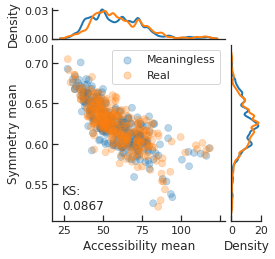

In [33]:
set_plot_params()

grid = sns.JointGrid(x=df.sort_values('targets')['accessibilities'], y=df.sort_values('targets')['symmetries'], 
                     data=df.sort_values('targets'), marginal_ticks=True)

g = grid.plot_joint(sns.scatterplot, hue='targets', data=df.sort_values('targets'), s=50, 
                    alpha=0.3, edgecolor='face')

g.ax_joint.set_ylabel('Symmetry mean')
g.ax_joint.set_xlabel('Accessibility mean')
g.ax_joint.tick_params(which='major', direction="in", left=True, bottom=True)
plt.setp(g.ax_joint.get_yticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)
plt.setp(g.ax_joint.get_xticklabels()[-1], visible=False)

leg = g.ax_joint.legend(loc="upper right", scatterpoints=1)
for lh in leg.legend_handles: 
    lh.set_alpha(0.3)
    lh.set_sizes([50])
    lh.set_edgecolors('face')

sns.kdeplot(x=df.loc[df['targets']=='Meaningless', 'accessibilities'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(x=df.loc[df['targets']=='Real', 'accessibilities'], ax=g.ax_marg_x, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='Meaningless', 'symmetries'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)
sns.kdeplot(y=df.loc[df['targets']=='Real', 'symmetries'], ax=g.ax_marg_y, 
            legend=False, bw_method=0.1, alpha=1, linewidth=2)

g.ax_marg_x.set_yticks([0.00, 0.03])
g.ax_marg_y.set_xticks([0, 20])

g.ax_marg_x.tick_params(which='major', direction="in", left=True)
g.ax_marg_y.tick_params(which='major', direction="in", bottom=True)

g.ax_joint.text(24, 0.52, "KS:\n" + 
                str(ks2d2s(np.array(df.loc[df['targets']=='Real', ['accessibilities', 'symmetries']]), 
                    np.array(df.loc[df['targets']=='Meaningless', ['accessibilities', 'symmetries']]))))

g.fig.set_size_inches((3.5, 3.5))
g.fig.set_rasterized(True)

g.savefig('access_sym.pdf', bbox_inches='tight', dpi=300)
plt.show()

____________

## Checking ROC-AUC

Ref: [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html)

In [35]:
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [36]:
random_state = np.random.RandomState(0)

def get_roc_and_aoc(X, y):
    cv = StratifiedKFold(n_splits=6)
    classifier = svm.SVC(kernel="linear", probability=True, random_state=random_state)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")


    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )


    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label 'Real')",
    )

    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

In [52]:
df_mesos = pd.DataFrame(data = np.zeros((len(real_nets) + len(shuffled_nets), 7)), 
                       columns = ["accessibility_h2_mean", "accessibility_h2_std", 
                                  "backbone_symmetry_h2_mean", "backbone_symmetry_h2_std",
                                  "merged_symmetry_h2_mean", "merged_symmetry_h2_std", 
                                  "Category"])

df_mesos

,accessibility_h2_mean,accessibility_h2_std,backbone_symmetry_h2_mean,backbone_symmetry_h2_std,merged_symmetry_h2_mean,merged_symmetry_h2_std,Category
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
path = "/content/drive/My Drive/PGCCMC/Projects/3. Mesoscopic/barbara_files/"

for book in tqdm(range(len(real_nets) + len(shuffled_nets))):
    complete_path = path + 'network_' 
    complete_path += real_index[book] if book < len(real_nets) \
                     else shuffled_index[(book - len(real_nets))] + '_RP' 
    complete_path += '.tsv'
        
    df = pd.read_csv(complete_path, sep='\t', header=0, dtype=float, float_precision='round_trip')

    # accessibility 
    df_mesos.loc[book, "accessibility_h2_mean"] = np.nanmean(df['Accessed Nodes h=2'])
    df_mesos.loc[book, "accessibility_h2_std"] = np.nanstd(df['Accessed Nodes h=2'])
    
    # backbone symmetry
    df_mesos.loc[book, "backbone_symmetry_h2_mean"] = np.nanmean(df['Backbone Accessibility h=2'])
    df_mesos.loc[book, "backbone_symmetry_h2_std"] = np.nanstd(df['Backbone Accessibility h=2'])
    
    # merged symmetry
    df_mesos.loc[book, "merged_symmetry_h2_mean"] = np.nanmean(df['Merged Accessibility h=2'])
    df_mesos.loc[book, "merged_symmetry_h2_std"] = np.nanstd(df['Merged Accessibility h=2'])
    
    
df_mesos["Category"] = ["Real"] * len(real_nets) + ["Meaningless"] * len(shuffled_nets)
    
    
df_mesos

  0%|          | 0/600 [00:00<?, ?it/s]

,accessibility_h2_mean,accessibility_h2_std,backbone_symmetry_h2_mean,backbone_symmetry_h2_std,merged_symmetry_h2_mean,merged_symmetry_h2_std,Category
0,73.905601,70.176387,0.619510,0.183569,0.562622,0.308432,Real
1,87.080889,88.997632,0.625845,0.211890,0.546501,0.323954,Real
2,30.490058,25.585737,0.732556,0.185396,0.752599,0.286438,Real
3,37.466247,28.467355,0.660641,0.182111,0.614311,0.295532,Real
4,75.905935,81.849601,0.652707,0.206982,0.608920,0.328361,Real
...,...,...,...,...,...,...,...
595,114.810314,98.447509,0.605286,0.184994,0.505895,0.308319,Meaningless
596,131.702413,128.478731,0.573159,0.224521,0.483043,0.343070,Meaningless
597,126.764017,119.163292,0.582760,0.203003,0.479412,0.327043,Meaningless
598,119.368284,98.808742,0.600123,0.159253,0.465233,0.286928,Meaningless


### Recurrence approach: accessibility mean vs. accessibility std

In [54]:
X = np.array(df_mesos[['accessibility_h2_mean', 'accessibility_h2_std']])
y = df_mesos[['Category']]['Category'].apply(lambda x: 1 if x in ["Real"] else 0)

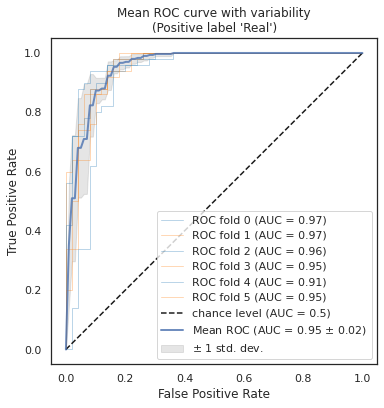

In [55]:
get_roc_and_aoc(X, y)

### Recurrence approach: accessibility mean vs. symmetry std

In [56]:
X = np.array(df_mesos[['accessibility_h2_mean', 'backbone_symmetry_h2_mean']])
y = df_mesos[['Category']]['Category'].apply(lambda x: 1 if x in ["Real"] else 0)

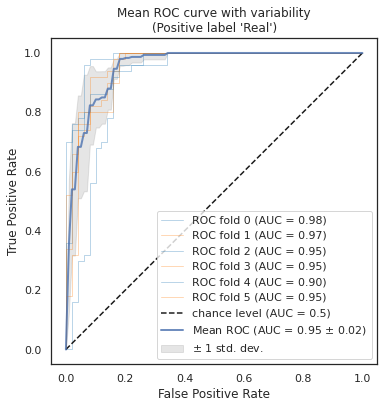

In [57]:
get_roc_and_aoc(X, y)

### Co-occurrence approach: accessibility mean vs. accessibility std

In [37]:
X = np.array(df_data[['accessibility_h2_mean', 'accessibility_h2_std']])
y = df_data[['Category']]['Category'].apply(lambda x: 1 if x in ["Real"] else 0)

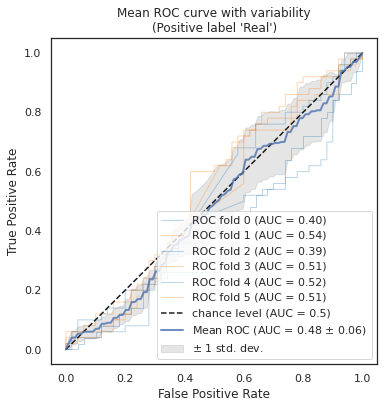

In [38]:
get_roc_and_aoc(X, y)

### Co-occurrence approach: accessibility mean vs. symmetry mean

In [41]:
X = np.array(df_data[['accessibility_h2_mean', 'backbone_symmetry_h2_mean']])
y = df_data[['Category']]['Category'].apply(lambda x: 1 if x in ["Real"] else 0)

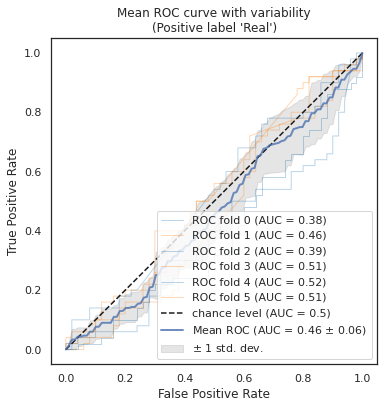

In [42]:
get_roc_and_aoc(X, y)